<a href="https://colab.research.google.com/github/brightblueshimmering/dtsa_5509/blob/main/airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NYC AirBnB Prices

#### Data Source: [Kaggle](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
df.shape

(48895, 16)

In [8]:
df = df.drop(['id','name','host_id','host_name','last_review'],axis=1)

In [9]:
obj_cols = df.select_dtypes(include='object').columns
objs = df[obj_cols]
for col in objs.columns:
    print(df[col].value_counts())
    print('-'*30)

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64
------------------------------
neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Fort Wadsworth           1
Richmondtown             1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: count, Length: 221, dtype: int64
------------------------------
room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64
------------------------------


In [10]:
df.isnull().sum()

,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0
minimum_nights,0
number_of_reviews,0
reviews_per_month,10052
calculated_host_listings_count,0


In [11]:
df['reviews_per_month'].isnull().sum()/len(df)

0.20558339298496778

In [12]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [13]:
df.duplicated().any()

False

# EDA

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,48895.0,40.728949,0.054530,40.49979,40.69010,40.72307,40.763115,40.91306
longitude,48895.0,-73.952170,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
price,48895.0,152.720687,240.154170,0.00000,69.00000,106.00000,175.000000,10000.00000
minimum_nights,48895.0,7.029962,20.510550,1.00000,1.00000,3.00000,5.000000,1250.00000
number_of_reviews,48895.0,23.274466,44.550582,0.00000,1.00000,5.00000,24.000000,629.00000
reviews_per_month,38843.0,1.373221,1.680442,0.01000,0.19000,0.72000,2.020000,58.50000
calculated_host_listings_count,48895.0,7.143982,32.952519,1.00000,1.00000,1.00000,2.000000,327.00000
availability_365,48895.0,112.781327,131.622289,0.00000,0.00000,45.00000,227.000000,365.00000


In [15]:
len(df[(df['price']==0)])

11

In [16]:
len(df[(df['number_of_reviews']==0)])

10052

In [17]:
df = df[df['price']!=0]
df.shape

(48884, 11)

In [18]:
#seperating col types
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

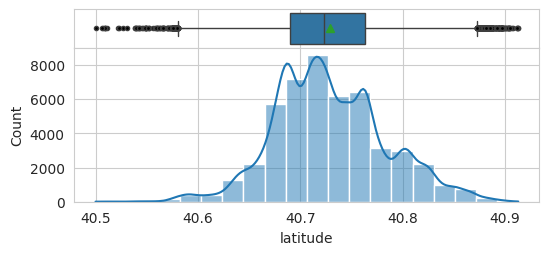

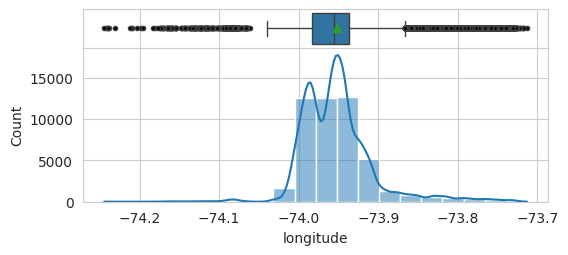

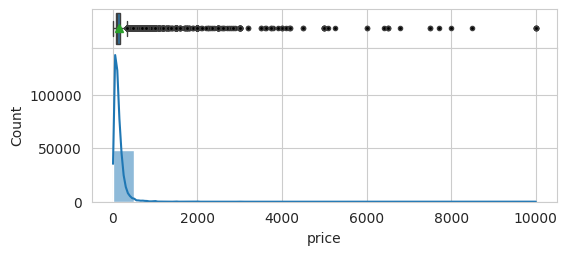

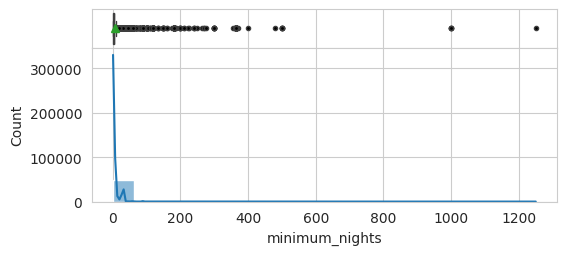

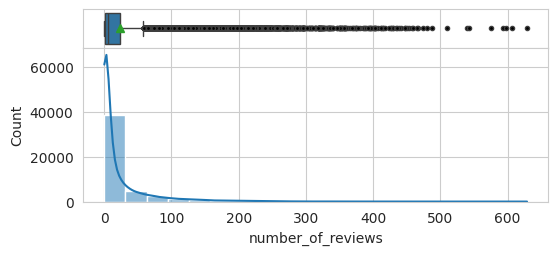

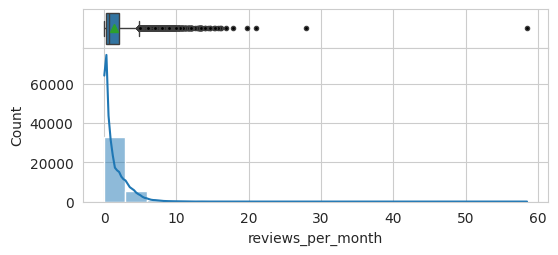

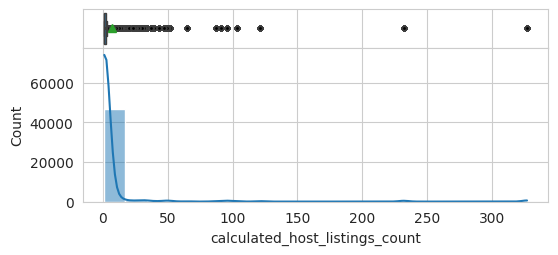

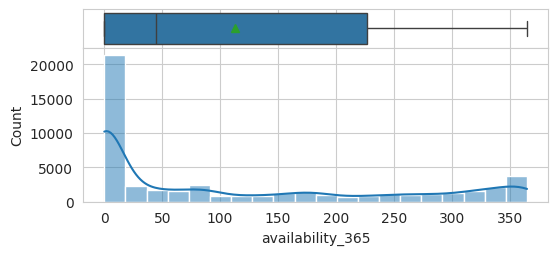

In [19]:
def hist_box(data, feature, figsize=(6, 2.5),bins=20):
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": [0.2, 0.8]}, figsize=figsize)

    flierprops = dict(marker='o', color='black', markersize=3, markerfacecolor='black')

    sns.boxplot(data=data, x=feature, ax=ax_box, showmeans=True, flierprops=flierprops)
    sns.histplot(data=data, x=feature, kde=True, ax=ax_hist,bins=bins)

    #removing labels and whitespace
    ax_box.set_xlabel('')
    ax_box.set_ylabel('')
    plt.subplots_adjust(hspace=0)

    return fig

for column in num_cols:
  hist_box(df, column)

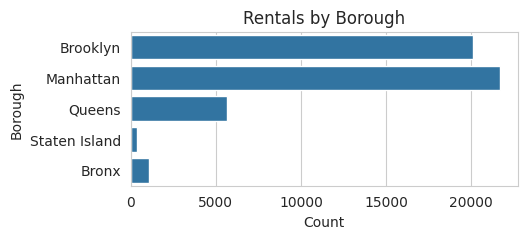

In [20]:
plt.figure(figsize=(5, 2))
sns.countplot(y=df['neighbourhood_group'])
plt.title('Rentals by Borough')
plt.ylabel('Borough')
plt.xlabel('Count')
plt.show()

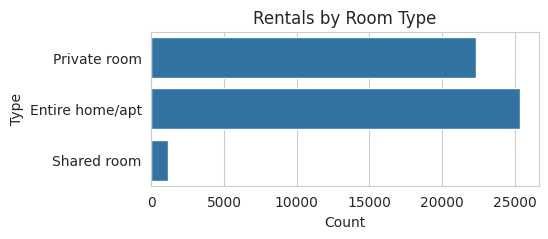

In [21]:
plt.figure(figsize=(5, 2))
sns.countplot(y=df['room_type'])
plt.title('Rentals by Room Type')
plt.ylabel('Type')
plt.xlabel('Count')
plt.show()

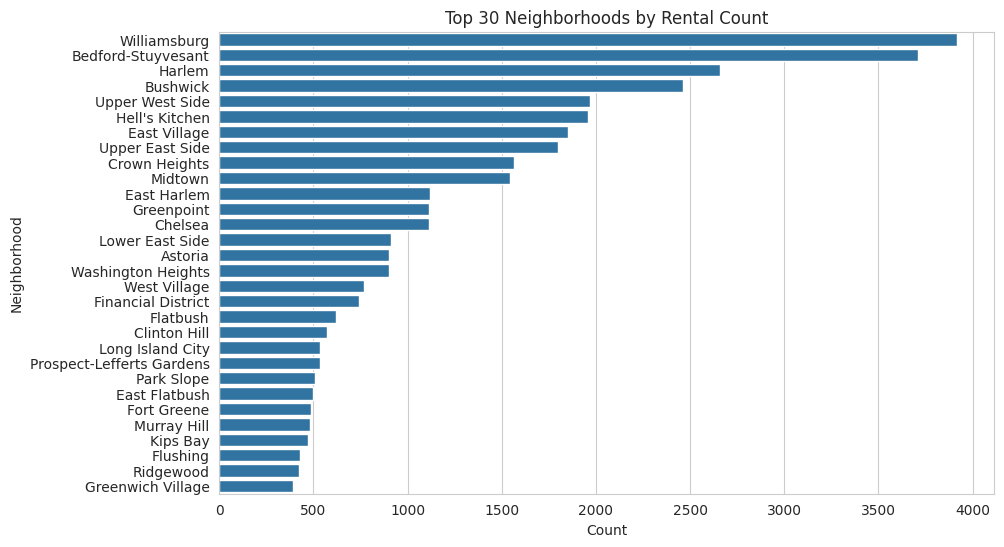

In [22]:
neighborhood_df = df.groupby('neighbourhood')['latitude'].count().sort_values(ascending=False).reset_index()
neighborhood_df.columns = ['neighbourhood','count']


plt.figure(figsize=(10, 6))
sns.barplot(y=neighborhood_df['neighbourhood'].head(30), x=neighborhood_df['count'].head(30))

plt.title('Top 30 Neighborhoods by Rental Count')
plt.ylabel('Neighborhood')
plt.xlabel('Count')
plt.show()

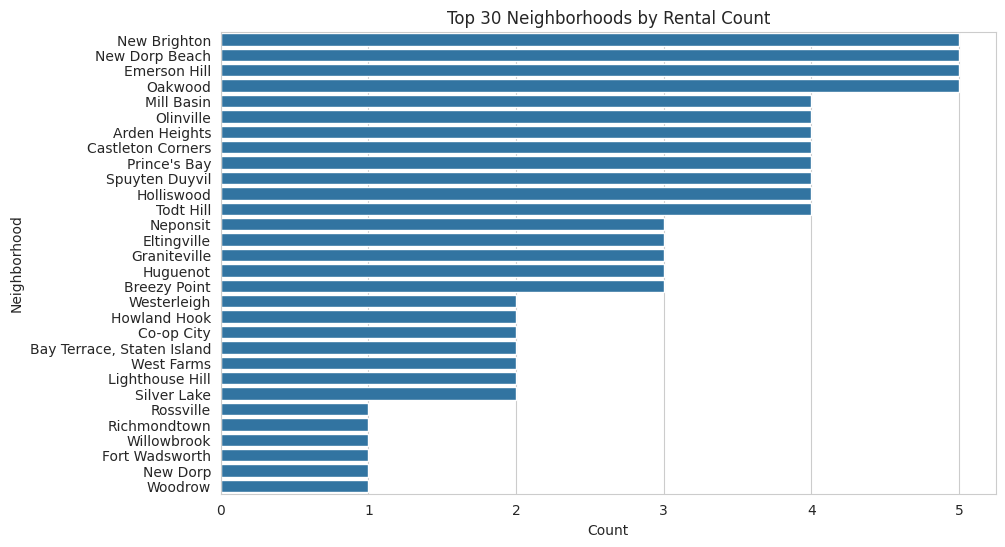

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(y=neighborhood_df['neighbourhood'].tail(30), x=neighborhood_df['count'].tail(30))

plt.title('Top 30 Neighborhoods by Rental Count')
plt.ylabel('Neighborhood')
plt.xlabel('Count')
plt.show()

In [24]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


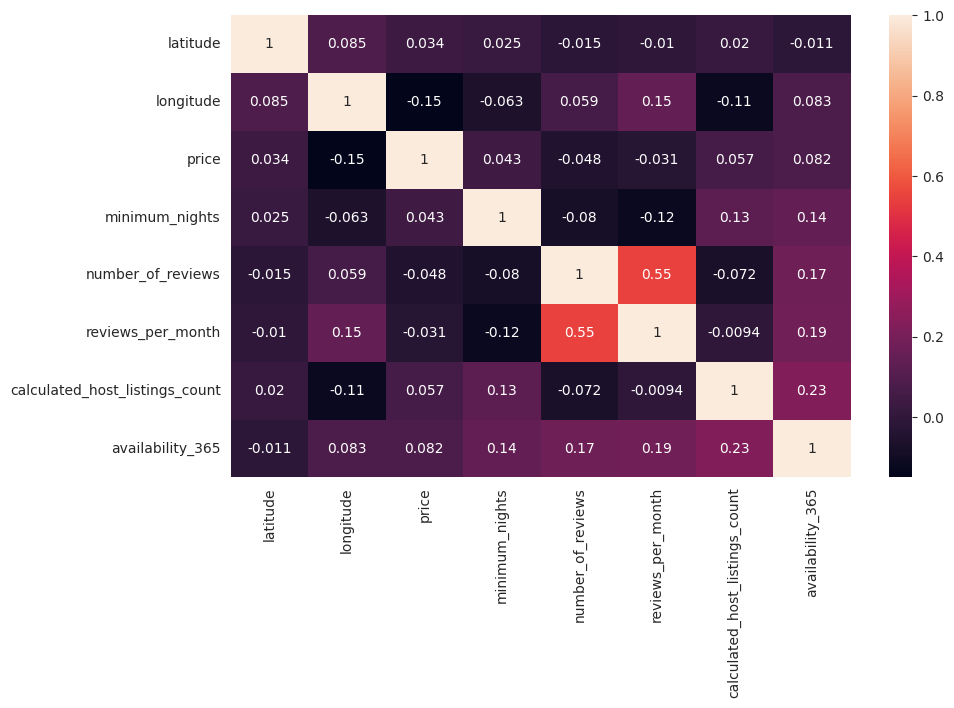

In [25]:
num_df = df[num_cols]
plt.figure(figsize=(10,6))
sns.heatmap(num_df.corr(),annot=True);

In [26]:
num_df.corr()['price'].sort_values(ascending=False)

,price
price,1.000000
availability_365,0.081847
calculated_host_listings_count,0.057462
minimum_nights,0.042805
latitude,0.033899
reviews_per_month,-0.030575
number_of_reviews,-0.047926
longitude,-0.149954


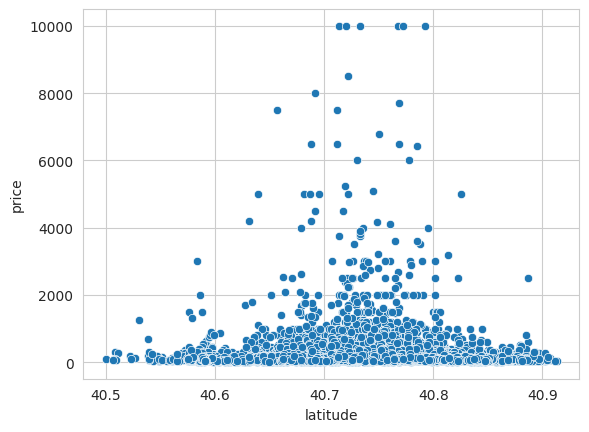

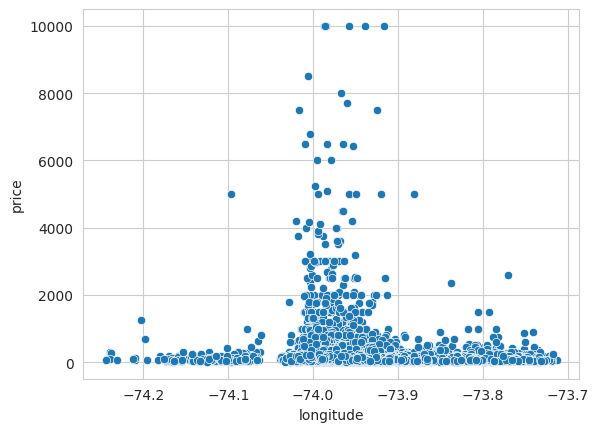

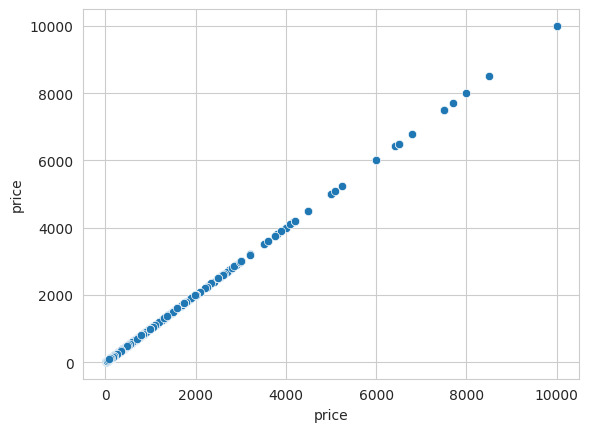

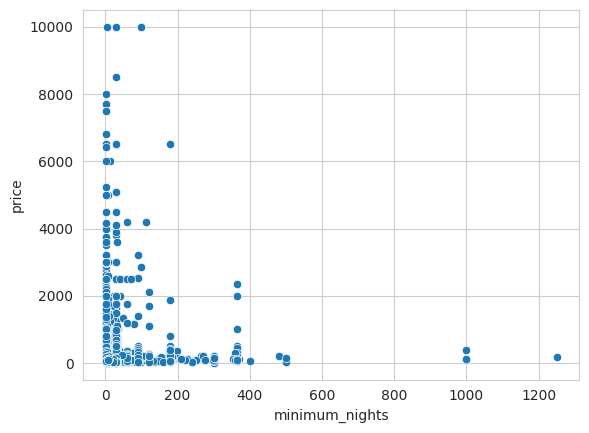

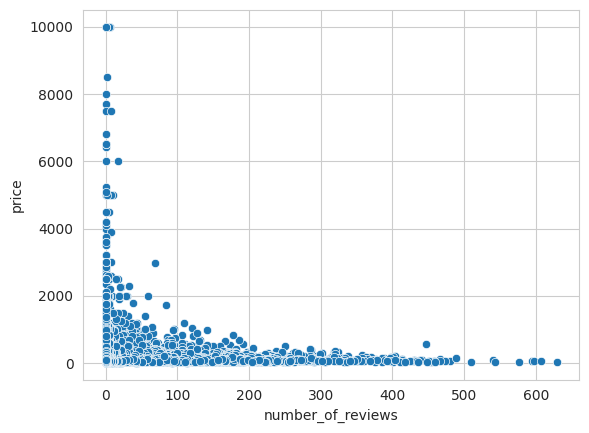

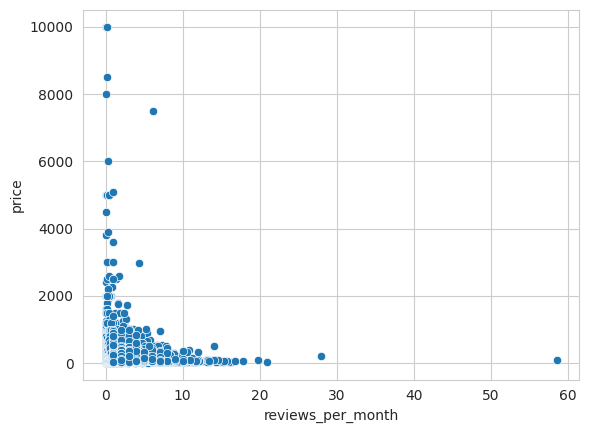

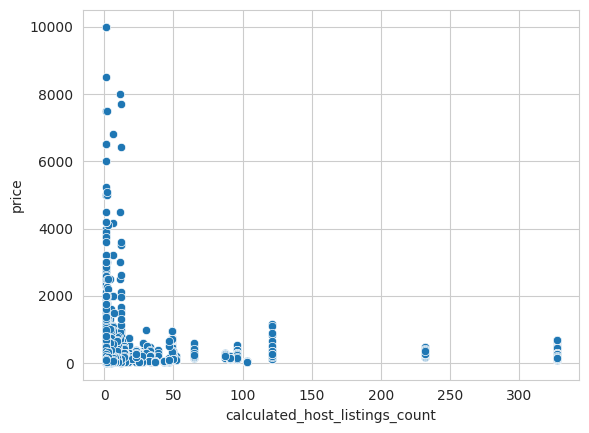

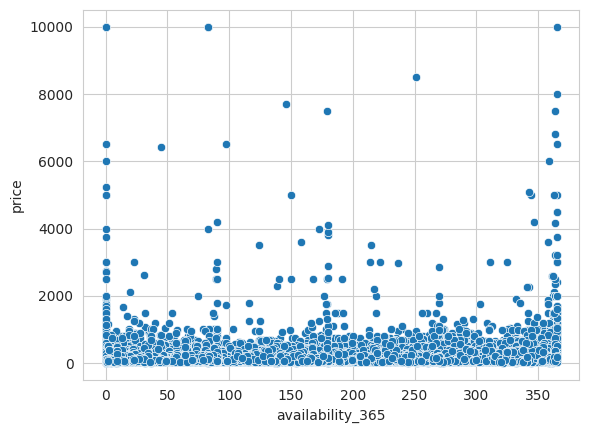

In [27]:
for num_col in num_cols:
  sns.scatterplot(data=df,y='price', x=num_col)
  plt.show()

In [29]:
df[df['reviews_per_month']>55]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,reviews_category
42075,Manhattan,Theater District,40.75918,-73.98801,Private room,100,1,156,58.5,9,299,high


In [30]:
avg_lat_long = df.sort_values('price',ascending=False)[['latitude','longitude']].head(100).mean()
avg_lat_long

,0
latitude,40.734607
longitude,-73.975653


In [31]:
# Reference point (40.735445, -73.975361)
lat_ref = 40.735445
long_ref = -73.975361

# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# Apply the Haversine function to each row in the DataFrame
df['distance_miles'] = df.apply(lambda row: haversine(lat_ref, long_ref, row['latitude'], row['longitude']), axis=1)

In [32]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,reviews_category,distance_miles
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,low,6.079191
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,low,1.330701
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365,NaN,5.376664
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,medium,3.570529
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,low,4.656403


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48884 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   neighbourhood_group             48884 non-null  object  
 1   neighbourhood                   48884 non-null  object  
 2   latitude                        48884 non-null  float64 
 3   longitude                       48884 non-null  float64 
 4   room_type                       48884 non-null  object  
 5   price                           48884 non-null  int64   
 6   minimum_nights                  48884 non-null  int64   
 7   number_of_reviews               48884 non-null  int64   
 8   reviews_per_month               38833 non-null  float64 
 9   calculated_host_listings_count  48884 non-null  int64   
 10  availability_365                48884 non-null  int64   
 11  reviews_category                38833 non-null  category
 12  distance_miles         

<Axes: xlabel='distance_miles', ylabel='price'>

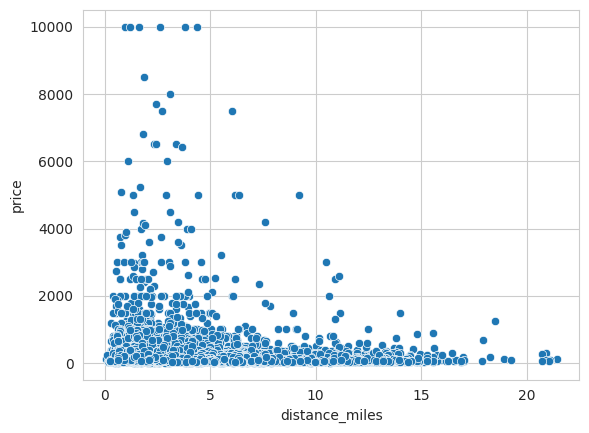

In [34]:
sns.scatterplot(data=df,y='price', x='distance_miles')

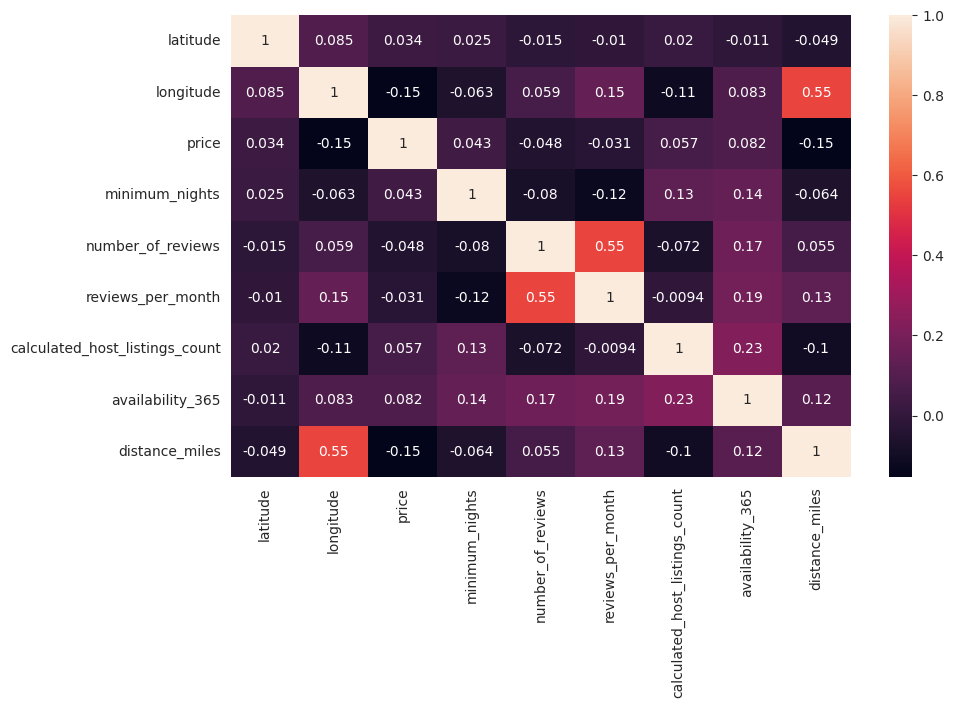

In [35]:
num_cols = df.select_dtypes(include=['number']).columns.tolist()
num_df = df[num_cols]
plt.figure(figsize=(10,6))
sns.heatmap(num_df.corr(),annot=True);

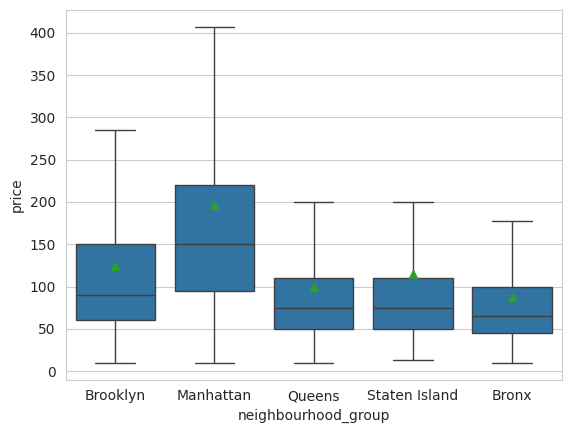

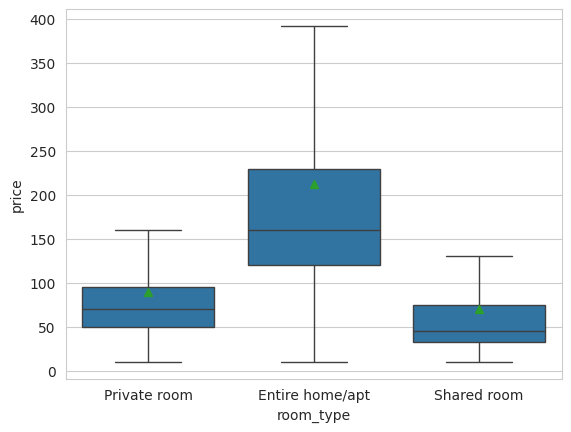

In [36]:
cat_cols.remove('neighbourhood')
for cat_col in cat_cols:
  sns.boxplot(data=df,y='price', x=cat_col,showmeans=True,showfliers=False)
  plt.show()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48884 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   neighbourhood_group             48884 non-null  object  
 1   neighbourhood                   48884 non-null  object  
 2   latitude                        48884 non-null  float64 
 3   longitude                       48884 non-null  float64 
 4   room_type                       48884 non-null  object  
 5   price                           48884 non-null  int64   
 6   minimum_nights                  48884 non-null  int64   
 7   number_of_reviews               48884 non-null  int64   
 8   reviews_per_month               38833 non-null  float64 
 9   calculated_host_listings_count  48884 non-null  int64   
 10  availability_365                48884 non-null  int64   
 11  reviews_category                38833 non-null  category
 12  distance_miles         

In [38]:
df['price_log'] = np.log(df['price'])
df = df.drop(['price'],axis=1)

In [39]:
# Convert all object columns to category data type
df = df.apply(lambda col: col.astype('category') if col.dtypes == 'object' else col)

# Verify the changes
print(df.dtypes)


neighbourhood_group               category
neighbourhood                     category
latitude                           float64
longitude                          float64
room_type                         category
minimum_nights                       int64
number_of_reviews                    int64
reviews_per_month                  float64
calculated_host_listings_count       int64
availability_365                     int64
reviews_category                  category
distance_miles                     float64
price_log                          float64
dtype: object


In [40]:
model_df = df.copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48884 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   neighbourhood_group             48884 non-null  category
 1   neighbourhood                   48884 non-null  category
 2   latitude                        48884 non-null  float64 
 3   longitude                       48884 non-null  float64 
 4   room_type                       48884 non-null  category
 5   minimum_nights                  48884 non-null  int64   
 6   number_of_reviews               48884 non-null  int64   
 7   reviews_per_month               38833 non-null  float64 
 8   calculated_host_listings_count  48884 non-null  int64   
 9   availability_365                48884 non-null  int64   
 10  reviews_category                38833 non-null  category
 11  distance_miles                  48884 non-null  float64 
 12  price_log              

In [41]:
# Splitting the data into features (X) and target (y)
y = model_df["price_log"]
X = model_df.drop(["price_log"], axis=1)
# Encoding categorical features (drop_first=True is used to avoid multicollinearity)
X = pd.get_dummies(X, drop_first=True)

#train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=462)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(29330, 236)
(9777, 236)
(9777, 236)


In [42]:
X.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance_miles,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,...,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Private room,room_type_Shared room,reviews_category_medium,reviews_category_high
0,40.64749,-73.97237,1,9,0.21,6,365,6.079191,True,False,...,False,False,False,False,False,False,True,False,False,False
1,40.75362,-73.98377,1,45,0.38,2,355,1.330701,False,True,...,False,False,False,False,False,False,False,False,False,False
2,40.80902,-73.94190,3,0,NaN,1,365,5.376664,False,True,...,False,False,False,False,False,False,True,False,False,False
3,40.68514,-73.95976,1,270,4.64,1,194,3.570529,True,False,...,False,False,False,False,False,False,False,False,True,False
4,40.79851,-73.94399,10,9,0.10,1,0,4.656403,False,True,...,False,False,False,False,False,False,False,False,False,False


In [43]:
#creating function to calculate rmse for train and test sets of given models
def calculate_rmse(models, X_train, y_train, preds, actuals):
    rmse_results = []

    for model in models:
        train_predics = model.predict(X_train)
        train_rmse = np.round(np.sqrt(mean_squared_error(y_train, train_predics)),5)
        test_predics = model.predict(preds)
        test_rmse = np.round(np.sqrt(mean_squared_error(actuals, test_predics)),5)
        # appending RMSE to a list of results
        rmse_results.append({"Model": model.__class__.__name__,"Train_RMSE": train_rmse,"Val_RMSE": test_rmse})
    rmse_df = pd.DataFrame(rmse_results)
    return rmse_df

In [44]:
# Decision Tree
tree_model = DecisionTreeRegressor(random_state = 1)
# Fitting the model
tree_model.fit(X_train, y_train)

# Random Forest Regressor
forest_model = RandomForestRegressor(n_estimators = 100, random_state = 1)
# Fitting the model
forest_model.fit(X_train, y_train)

# XGBoost Regressor
boost_model = XGBRegressor(random_state = 1)
# Fitting the model
boost_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [63]:
def n_features_importance_plot(model,name,top_n=15):
  features = list(X.columns)
  importances = model.feature_importances_
  df = pd.DataFrame({'Feature': features, 'Importance': importances})
  df = df.sort_values(by='Importance', ascending=False)
  #plot
  plt.figure(figsize=(18, 4))
  ax = sns.barplot(x='Importance', y='Feature', data=df.head(top_n), palette="light:b_r")
  plt.title(f'{name} | Top {top_n} Features');

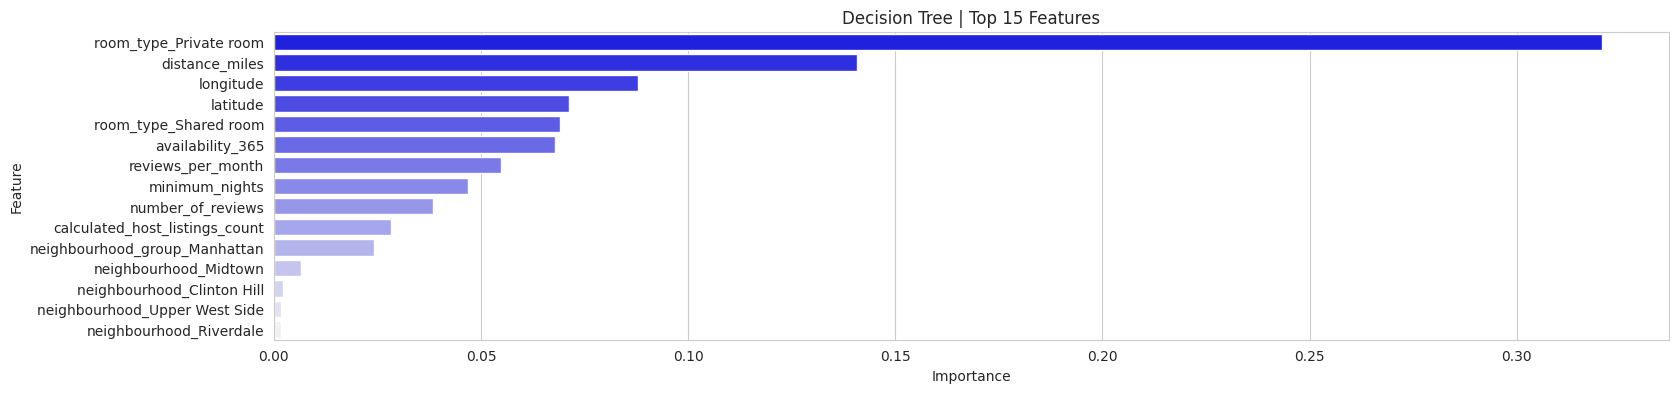

In [64]:
n_features_importance_plot(tree_model,'Decision Tree')

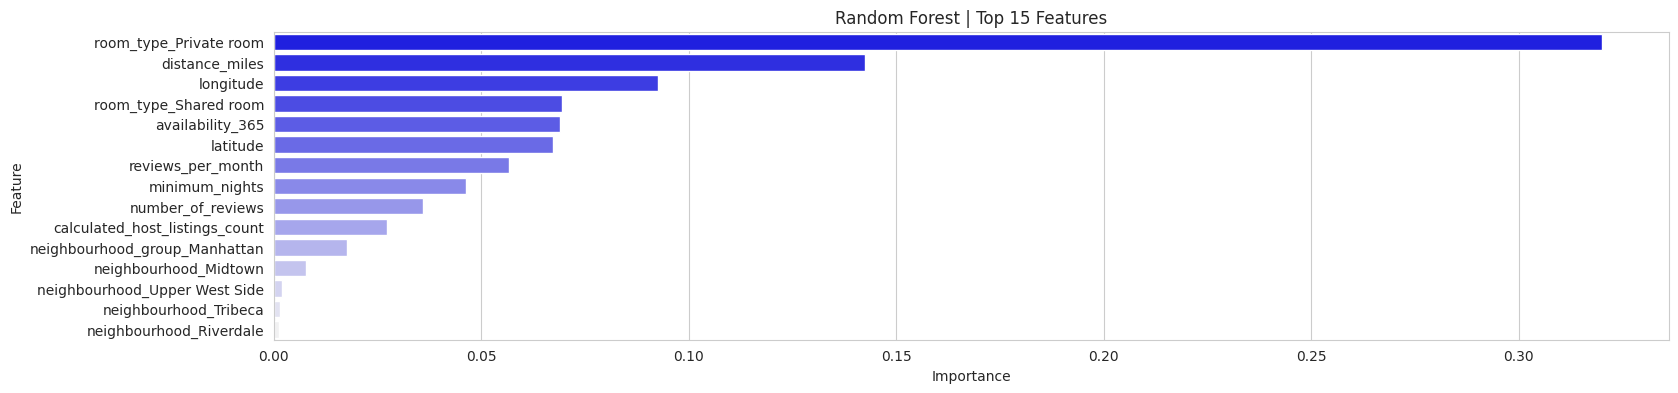

In [65]:
n_features_importance_plot(forest_model,'Random Forest')

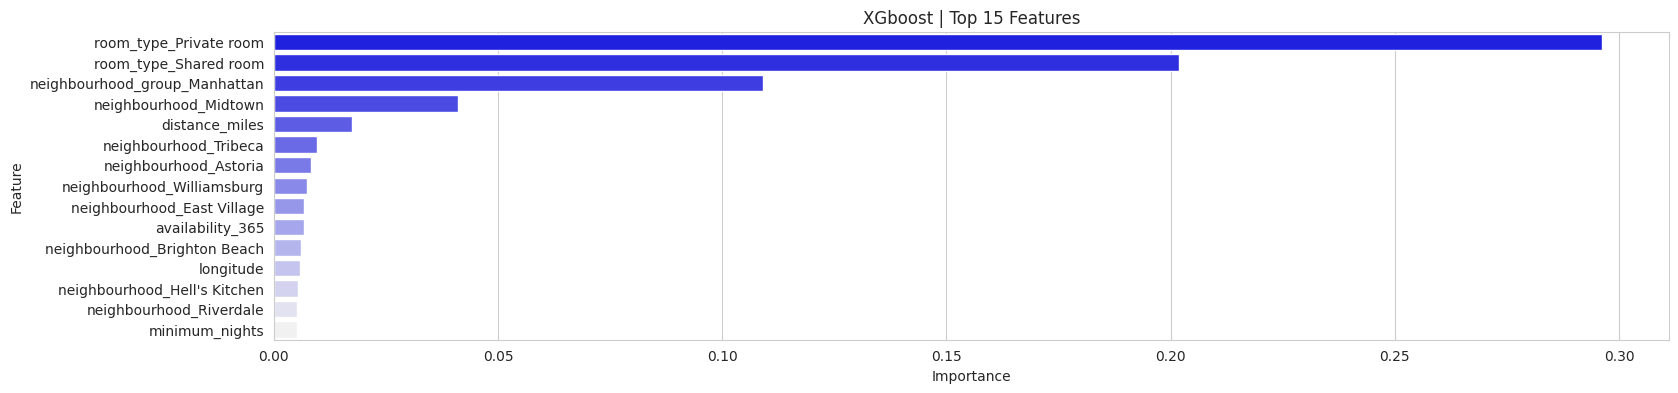

In [66]:
n_features_importance_plot(boost_model,'XGboost')

In [49]:
models = [tree_model,forest_model,boost_model]
calculate_rmse(models, X_train, y_train, X_val, y_val)

,Model,Train_RMSE,Val_RMSE
0,DecisionTreeRegressor,0.03910,0.62006
1,RandomForestRegressor,0.16695,0.44527
2,XGBRegressor,0.37699,0.44219


In [50]:
#tuning boost
tuned_boost = XGBRegressor(random_state = 1)

#paramgrid
boost_parameters = {'n_estimators': [100, 200, 300,],'learning_rate': [0.01,0.05, 0.1, 0.2],'max_depth': [3, 4, 5]}
boost_grid = GridSearchCV(tuned_boost, boost_parameters, scoring = 'neg_mean_squared_error', cv = 5)

boost_grid = boost_grid.fit(X_train, y_train)
#tuning to best combination of parameters
tuned_boost = boost_grid.best_estimator_
#fitting model
tuned_boost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=1, ...)

In [51]:
models = [tuned_boost]
test_df = calculate_rmse(models, X_train, y_train, X_test, y_test)
all_df = calculate_rmse(models, X_train, y_train, X_val, y_val)
# Add the last column of df1 to df2
all_df['Test_RMSE '] = test_df.iloc[:, -1]
all_df = all_df.rename(columns={'Test_RMSE':'Validation_RMSE'})
all_df

,Model,Train_RMSE,Val_RMSE,Test_RMSE
0,XGBRegressor,0.39902,0.44099,0.44086


In [67]:
MSE = np.round(np.exp(all_df['Test_RMSE '].values[0]),2)
MSE

1.55